# **Projeto - Redes Convolucionais**

### **Download dataset**

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.python.keras.callbacks import EarlyStopping

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-05-16 22:35:09--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  28.7MB/s    in 30s     

2022-05-16 22:35:40 (25.0 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-05-16 22:35:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  14.3MB/s    in 1.3s    

2022-05-16 22:35:42 (14.3 M

In [3]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

## **Cats and dogs**

### **Prepare data**

In [4]:
IMAGE_BASE_PATH = 'images'
SAMPLE_FILES = 'annotations/list.txt'
TRAIN_FILES = 'annotations/trainval.txt'
TEST_FILES = 'annotations/test.txt'

files = open(TRAIN_FILES)
train_files = []
train_labels = []
for txt_line in files:
    if txt_line[0] == '#':
        continue
    file_name, class_id, cat_dog_id, sub_class_id = txt_line.split(' ')
    train_files.append(file_name + '.jpg')
    train_labels.append(cat_dog_id)
files.close()

train_data_frame = pd.DataFrame({'filename': train_files, 'label': train_labels})

In [5]:
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                        subset='training',
                                        shuffle=True,
                                        seed=42)

val_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                      directory=IMAGE_BASE_PATH,
                                      x_col='filename',
                                      y_col='label',
                                      target_size=(128, 128),
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      subset='validation',
                                      shuffle=True,
                                      seed=42)

Found 2944 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.


### **Model - VGG16**

In [7]:
from tensorflow import keras

#### Rede pré-treinada

In [8]:
#Pré treinada

rede = keras.applications.VGG16(
    weights="imagenet",  
    input_shape=(128, 128, 3),
    include_top=False,
)

rede.trainable=False

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
def nova_rede_pre_treinada(base_model):
    resolucao = (5, 5)
    pool_size = (2, 2)
    n_filtros = 32

    inputs = keras.Input(shape=(32, 32, 3))

    dense1 = Dense(32, activation='relu')
    dense2 = Dense(64, activation='relu')
    dense3 = Dense(128, activation='relu')
    dense4 = Dense(256, activation='relu')
    dense5 = Dense(512, activation='relu')

    flatten = Flatten()
    dense = Dense(2, activation='softmax')

    model = Sequential([
            base_model,
            flatten,
            dense2,
            dense3,
            dense4,
            dense
        ])

    return model

model = nova_rede_pre_treinada(rede)
    
# Definicao de otimizadores
model.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam',
                     metrics = ['accuracy'])


In [11]:
import matplotlib.pyplot as plt

def plot_model_loss(historico):
    loss = historico.history['loss']
    val_loss = historico.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot_model_accuracy(historico):
    accuracy = historico.history['accuracy']
    val_accuracy = historico.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()


In [12]:
es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 10)
historico = model.fit_generator(train_dataset,
                        steps_per_epoch = train_dataset.samples // 64,
                        validation_data = val_dataset,
                        validation_steps = val_dataset.samples // 64,
                        epochs=32,
                        callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
46/46 [==============================] - 24s 455ms/step - loss: 0.4308 - accuracy: 0.8030 - val_loss: 0.4036 - val_accuracy: 0.8153
Epoch 2/32
46/46 [==============================] - 21s 453ms/step - loss: 0.2424 - accuracy: 0.8961 - val_loss: 0.2290 - val_accuracy: 0.8920
Epoch 3/32
46/46 [==============================] - 26s 581ms/step - loss: 0.1588 - accuracy: 0.9385 - val_loss: 0.2769 - val_accuracy: 0.8835
Epoch 4/32
46/46 [==============================] - 23s 508ms/step - loss: 0.1132 - accuracy: 0.9538 - val_loss: 0.4257 - val_accuracy: 0.8509
Epoch 5/32
46/46 [==============================] - 24s 522ms/step - loss: 0.0656 - accuracy: 0.9762 - val_loss: 0.3932 - val_accuracy: 0.8665
Epoch 6/32
46/46 [==============================] - 23s 512ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.4089 - val_accuracy: 0.8963
Epoch 7/32
46/46 [==============================] - 28s 622ms/step - loss: 0.0698 - accuracy: 0.9664 - val_loss: 0.6064 - val_accuracy: 0.8580

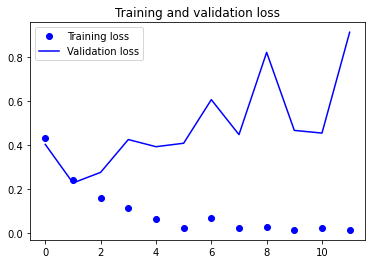

In [13]:
plot_model_loss(historico)

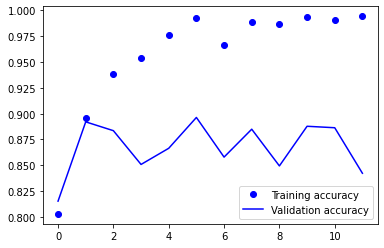

In [14]:
plot_model_accuracy(historico)

Considerando a acurácia de treino e validação, percebe-se que houve overfitting do modelo. A acurácia de treinamento ficou maior que 0.99, porém a de validação ficou com 0.84

#### Descongelamento parcial

In [15]:
#Descongelamento parcial

rede = keras.applications.VGG16(
    weights="imagenet",  
    input_shape=(128, 128, 3),
    include_top=False,
)

rede.layers[18].trainable = False

for layer in rede.layers[:len(rede.layers)//2]:
   layer.trainable = False
for layer in rede.layers[len(rede.layers)//2:]:
   layer.trainable = True

In [16]:
model = nova_rede_pre_treinada(rede)

In [17]:
# Definicao de otimizadores
model.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam',
                     metrics = ['accuracy'])


es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 10)
historico = model.fit_generator(train_dataset,
                        steps_per_epoch = train_dataset.samples // 64,
                        validation_data = val_dataset,
                        validation_steps = val_dataset.samples // 64,
                        epochs=32,
                        callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
46/46 [==============================] - 29s 510ms/step - loss: 1.4377 - accuracy: 0.6746 - val_loss: 0.6728 - val_accuracy: 0.5980
Epoch 2/32
46/46 [==============================] - 26s 570ms/step - loss: 0.6247 - accuracy: 0.6882 - val_loss: 0.6782 - val_accuracy: 0.5994
Epoch 3/32
46/46 [==============================] - 31s 687ms/step - loss: 0.6307 - accuracy: 0.6834 - val_loss: 0.6813 - val_accuracy: 0.5909
Epoch 4/32
46/46 [==============================] - 24s 536ms/step - loss: 0.6135 - accuracy: 0.6970 - val_loss: 0.6861 - val_accuracy: 0.6037
Epoch 5/32
46/46 [==============================] - 22s 490ms/step - loss: 0.6093 - accuracy: 0.6926 - val_loss: 0.6247 - val_accuracy: 0.6577
Epoch 6/32
46/46 [==============================] - 23s 506ms/step - loss: 0.5910 - accuracy: 0.6902 - val_loss: 0.6659 - val_accuracy: 0.5966
Epoch 7/32
46/46 [==============================] - 23s 498ms/step - loss: 0.5679 - accuracy: 0.7062 - val_loss: 0.6316 - val_accuracy: 0.6520

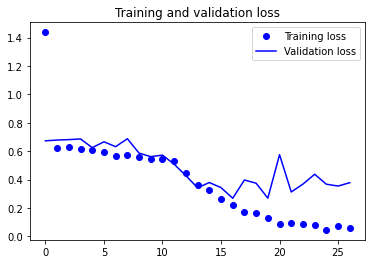

In [18]:
plot_model_loss(historico)

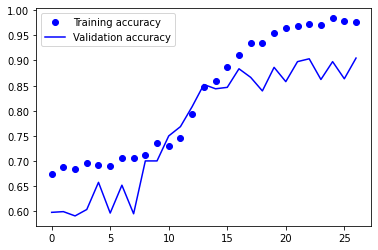

In [19]:
plot_model_accuracy(historico)

Comparando com a rede pré-treinada, o modelo com descongelamento parcial (meio a meio) performou melhor e teve menos overfitting. A acurácia de validação ficou maior, em 0.90. Além disso, o val_loss caiu bastante, de 0.91 para 0.37

#### Descongelamento total

In [20]:
#Descongelamento total

rede = keras.applications.VGG16(
    weights="imagenet",  
    input_shape=(128, 128, 3),
    include_top=False,
)

rede.trainable = True

In [21]:
model = nova_rede_pre_treinada(rede)

In [22]:
# Definicao de otimizadores
model.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam',
                     metrics = ['accuracy'])


es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 10)
historico = model.fit_generator(train_dataset,
                        steps_per_epoch = train_dataset.samples // 64,
                        validation_data = val_dataset,
                        validation_steps = val_dataset.samples // 64,
                        epochs=32,
                        callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
46/46 [==============================] - 38s 746ms/step - loss: 0.7215 - accuracy: 0.6705 - val_loss: 0.7258 - val_accuracy: 0.5980
Epoch 2/32
46/46 [==============================] - 34s 740ms/step - loss: 0.6269 - accuracy: 0.6923 - val_loss: 0.6747 - val_accuracy: 0.5923
Epoch 3/32
46/46 [==============================] - 34s 742ms/step - loss: 0.6067 - accuracy: 0.7014 - val_loss: 0.7414 - val_accuracy: 0.5994
Epoch 4/32
46/46 [==============================] - 34s 742ms/step - loss: 0.6167 - accuracy: 0.6950 - val_loss: 0.7280 - val_accuracy: 0.6009
Epoch 5/32
46/46 [==============================] - 34s 740ms/step - loss: 0.6177 - accuracy: 0.6946 - val_loss: 0.6810 - val_accuracy: 0.6009
Epoch 6/32
46/46 [==============================] - 34s 741ms/step - loss: 0.6181 - accuracy: 0.6967 - val_loss: 0.6732 - val_accuracy: 0.5994
Epoch 7/32
46/46 [==============================] - 34s 742ms/step - loss: 0.6084 - accuracy: 0.6967 - val_loss: 0.6502 - val_accuracy: 0.5966

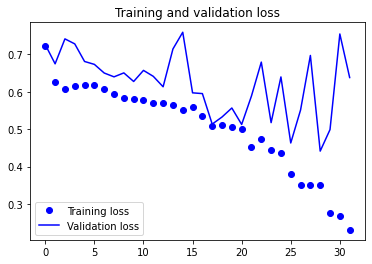

In [23]:
plot_model_loss(historico)

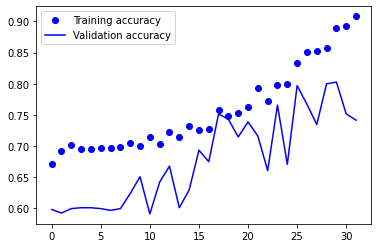

In [24]:
plot_model_accuracy(historico)

Comparando com as redes anteriores este modelo a pior performance considerando as acurácias de treino e validação. O val_loss ficou melhor do que a rede pré-treinada, mas ainda assim, ficou pior do que a rede com descongelamento parcial.